# Ch9. Specification and Data Issues

In [1]:
%pip install matplotlib numpy pandas statsmodels wooldridge scipy -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as smo
import wooldridge as wool
from scipy import stats

## 9.1 Functional Form Misspecification

### Example 9.2: Housing Price Equation

In [3]:
hprice1 = wool.data("hprice1")

# original OLS:
reg = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results = reg.fit()

# regression for RESET test:
hprice1["fitted_sq"] = results.fittedvalues**2
hprice1["fitted_cub"] = results.fittedvalues**3
reg_reset = smf.ols(
    formula="price ~ lotsize + sqrft + bdrms + fitted_sq + fitted_cub",
    data=hprice1,
)
results_reset = reg_reset.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results_reset.params, 4),
        "se": round(results_reset.bse, 4),
        "t": round(results_reset.tvalues, 4),
        "pval": round(results_reset.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                   b        se       t    pval
Intercept   166.0973  317.4325  0.5233  0.6022
lotsize       0.0002    0.0052  0.0295  0.9765
sqrft         0.0176    0.2993  0.0588  0.9532
bdrms         2.1749   33.8881  0.0642  0.9490
fitted_sq     0.0004    0.0071  0.0498  0.9604
fitted_cub    0.0000    0.0000  0.2358  0.8142



In [4]:
# RESET test (H0: all coeffs including "fitted" are=0):
hypotheses = ["fitted_sq = 0", "fitted_cub = 0"]
ftest_man = results_reset.f_test(hypotheses)
fstat_man = ftest_man.statistic
fpval_man = ftest_man.pvalue

print(f"fstat_man: {fstat_man}\n")
print(f"fpval_man: {fpval_man}\n")

fstat_man: 4.668205534946464

fpval_man: 0.012021711442908005



In [5]:
hprice1 = wool.data("hprice1")

# original linear regression:
reg = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results = reg.fit()

# automated RESET test:
reset_output = smo.reset_ramsey(res=results, degree=3)
fstat_auto = reset_output.statistic
fpval_auto = reset_output.pvalue

print(f"fstat_auto: {fstat_auto}\n")
print(f"fpval_auto: {fpval_auto}\n")

fstat_auto: 4.668205534948772

fpval_auto: 0.012021711442883198



In [6]:
hprice1 = wool.data("hprice1")

# two alternative models:
reg1 = smf.ols(formula="price ~ lotsize + sqrft + bdrms", data=hprice1)
results1 = reg1.fit()

reg2 = smf.ols(
    formula="price ~ np.log(lotsize) +np.log(sqrft) + bdrms",
    data=hprice1,
)
results2 = reg2.fit()

# encompassing test of Davidson & MacKinnon:
# comprehensive model:
reg3 = smf.ols(
    formula="price ~ lotsize + sqrft + bdrms + np.log(lotsize) + np.log(sqrft)",
    data=hprice1,
)
results3 = reg3.fit()

# model 1 vs. comprehensive model:
anovaResults1 = sm.stats.anova_lm(results1, results3)
print(f"anovaResults1: \n{anovaResults1}\n")

anovaResults1: 
   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0      84.0  300723.805123      0.0           NaN       NaN       NaN
1      82.0  252340.364481      2.0  48383.440642  7.861291  0.000753



In [7]:
# model 2 vs. comprehensive model:
anovaResults2 = sm.stats.anova_lm(results2, results3)
print(f"anovaResults2: \n{anovaResults2}\n")

anovaResults2: 
   df_resid            ssr  df_diff       ss_diff        F    Pr(>F)
0      84.0  295735.273607      0.0           NaN      NaN       NaN
1      82.0  252340.364481      2.0  43394.909126  7.05076  0.001494



## 9.2 Measurement Error

In [8]:
# set the random seed:
np.random.seed(1234567)

# set sample size and number of simulations:
n = 1000
r = 10000

# set true parameters (betas):
beta0 = 1
beta1 = 0.5

# initialize arrays to store results later (b1 without ME, b1_me with ME):
b1 = np.empty(r)
b1_me = np.empty(r)

# draw a sample of x, fixed over replications:
x = stats.norm.rvs(4, 1, size=n)

# repeat r times:
for i in range(r):
    # draw a sample of u:
    u = stats.norm.rvs(0, 1, size=n)

    # draw a sample of ystar:
    ystar = beta0 + beta1 * x + u

    # measurement error and mismeasured y:
    e0 = stats.norm.rvs(0, 1, size=n)
    y = ystar + e0
    df = pd.DataFrame({"ystar": ystar, "y": y, "x": x})

    # regress ystar on x and store slope estimate at position i:
    reg_star = smf.ols(formula="ystar ~ x", data=df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["x"]

    # regress y on x and store slope estimate at position i:
    reg_me = smf.ols(formula="y ~ x", data=df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]

# mean with and without ME:
b1_mean = np.mean(b1)
b1_me_mean = np.mean(b1_me)
print(f"b1_mean: {b1_mean}\n")
print(f"b1_me_mean: {b1_me_mean}\n")

b1_mean: 0.5002159846382418

b1_me_mean: 0.4999676458235338



In [9]:
# variance with and without ME:
b1_var = np.var(b1, ddof=1)
b1_me_var = np.var(b1_me, ddof=1)
print(f"b1_var: {b1_var}\n")
print(f"b1_me_var: {b1_me_var}\n")

b1_var: 0.0010335543409510668

b1_me_var: 0.0020439380493408005



In [10]:
# set the random seed:
np.random.seed(1234567)

# set sample size and number of simulations:
n = 1000
r = 10000

# set true parameters (betas):
beta0 = 1
beta1 = 0.5

# initialize b1 arrays to store results later:
b1 = np.empty(r)
b1_me = np.empty(r)

# draw a sample of x, fixed over replications:
xstar = stats.norm.rvs(4, 1, size=n)

# repeat r times:
for i in range(r):
    # draw a sample of u:
    u = stats.norm.rvs(0, 1, size=n)

    # draw a sample of y:
    y = beta0 + beta1 * xstar + u

    # measurement error and mismeasured x:
    e1 = stats.norm.rvs(0, 1, size=n)
    x = xstar + e1
    df = pd.DataFrame({"y": y, "xstar": xstar, "x": x})

    # regress y on xstar and store slope estimate at position i:
    reg_star = smf.ols(formula="y ~ xstar", data=df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["xstar"]

    # regress y on x and store slope estimate at position i:
    reg_me = smf.ols(formula="y ~ x", data=df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]

# mean with and without ME:
b1_mean = np.mean(b1)
b1_me_mean = np.mean(b1_me)
print(f"b1_mean: {b1_mean}\n")
print(f"b1_me_mean: {b1_me_mean}\n")

b1_mean: 0.5002159846382418

b1_me_mean: 0.2445467197788616



In [11]:
# variance with and without ME:
b1_var = np.var(b1, ddof=1)
b1_me_var = np.var(b1_me, ddof=1)
print(f"b1_var: {b1_var}\n")
print(f"b1_me_var: {b1_me_var}\n")

b1_var: 0.0010335543409510668

b1_me_var: 0.0005435611029837354



## 9.3 Missing Data and Nonrandom Samples

In [12]:
# nan and inf handling in numpy:
x = np.array([-1, 0, 1, np.nan, np.inf, -np.inf])
logx = np.log(x)
invx = np.array(1 / x)
ncdf = np.array(stats.norm.cdf(x))
isnanx = np.isnan(x)

results = pd.DataFrame(
    {"x": x, "logx": logx, "invx": invx, "logx": logx, "ncdf": ncdf, "isnanx": isnanx},
)
print(f"results: \n{results}\n")

results: 
     x  logx  invx      ncdf  isnanx
0 -1.0   NaN  -1.0  0.158655   False
1  0.0  -inf   inf  0.500000   False
2  1.0   0.0   1.0  0.841345   False
3  NaN   NaN   NaN       NaN    True
4  inf   inf   0.0  1.000000   False
5 -inf   NaN  -0.0  0.000000   False



/tmp/ipykernel_16428/3106953107.py:3: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)
/tmp/ipykernel_16428/3106953107.py:3: RuntimeWarning: invalid value encountered in log
  logx = np.log(x)
/tmp/ipykernel_16428/3106953107.py:4: RuntimeWarning: divide by zero encountered in divide
  invx = np.array(1 / x)


In [13]:
lawsch85 = wool.data("lawsch85")
lsat_pd = lawsch85["LSAT"]

# create boolean indicator for missings:
missLSAT = lsat_pd.isna()

# LSAT and indicator for Schools No. 120-129:
preview = pd.DataFrame({"lsat_pd": lsat_pd[119:129], "missLSAT": missLSAT[119:129]})
print(f"preview: \n{preview}\n")

preview: 
     lsat_pd  missLSAT
119    156.0     False
120    159.0     False
121    157.0     False
122    167.0     False
123      NaN      True
124    158.0     False
125    155.0     False
126    157.0     False
127      NaN      True
128    163.0     False



In [14]:
# frequencies of indicator:
freq_missLSAT = pd.crosstab(missLSAT, columns="count")
print(f"freq_missLSAT: \n{freq_missLSAT}\n")

freq_missLSAT: 
col_0  count
LSAT        
False    150
True       6



In [15]:
# missings for all variables in data frame (counts):
miss_all = lawsch85.isna()
colsums = miss_all.sum(axis=0)
print(f"colsums: \n{colsums}\n")

colsums: 
rank        0
salary      8
cost        6
LSAT        6
GPA         7
libvol      1
faculty     4
age        45
clsize      3
north       0
south       0
east        0
west        0
lsalary     8
studfac     6
top10       0
r11_25      0
r26_40      0
r41_60      0
llibvol     1
lcost       6
dtype: int64



In [16]:
# computing amount of complete cases:
complete_cases = miss_all.sum(axis=1) == 0
freq_complete_cases = pd.crosstab(complete_cases, columns="count")
print(f"freq_complete_cases: \n{freq_complete_cases}\n")

freq_complete_cases: 
col_0  count
row_0       
False     66
True      90



In [17]:
lawsch85 = wool.data("lawsch85")

# missings in numpy:
x_np = np.array(lawsch85["LSAT"])
x_np_bar1 = np.mean(x_np)
x_np_bar2 = np.nanmean(x_np)
print(f"x_np_bar1: {x_np_bar1}\n")
print(f"x_np_bar2: {x_np_bar2}\n")

x_np_bar1: nan

x_np_bar2: 158.29333333333332



In [18]:
# missings in pandas:
x_pd = lawsch85["LSAT"]
x_pd_bar1 = np.mean(x_pd)
x_pd_bar2 = np.nanmean(x_pd)
print(f"x_pd_bar1: {x_pd_bar1}\n")
print(f"x_pd_bar2: {x_pd_bar2}\n")

x_pd_bar1: 158.29333333333332

x_pd_bar2: 158.29333333333332



In [19]:
# observations and variables:
print(f"lawsch85.shape: {lawsch85.shape}\n")

lawsch85.shape: (156, 21)



In [20]:
# regression (missings are taken care of by default):
reg = smf.ols(formula="np.log(salary) ~ LSAT + cost + age", data=lawsch85)
results = reg.fit()
print(f"results.nobs: {results.nobs}\n")

results.nobs: 95.0



## 9.4 Outlying Observations

In [21]:
rdchem = wool.data("rdchem")

# OLS regression:
reg = smf.ols(formula="rdintens ~ sales + profmarg", data=rdchem)
results = reg.fit()

# studentized residuals for all observations:
studres = results.get_influence().resid_studentized_external

# display extreme values:
studres_max = np.max(studres)
studres_min = np.min(studres)
print(f"studres_max: {studres_max}\n")
print(f"studres_min: {studres_min}\n")

studres_max: 4.555033421514247

studres_min: -1.8180393952811693



Text(0.5, 0, 'studres')

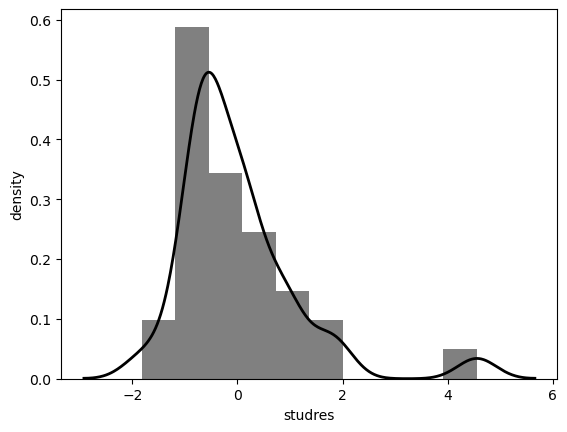

In [22]:
# histogram (and overlayed density plot):
kde = sm.nonparametric.KDEUnivariate(studres)
kde.fit()

plt.hist(studres, color="grey", density=True)
plt.plot(kde.support, kde.density, color="black", linewidth=2)
plt.ylabel("density")
plt.xlabel("studres")

## 9.5 Least Absolute Deviations (LAD) Estimation

In [23]:
rdchem = wool.data("rdchem")

# OLS regression:
reg_ols = smf.ols(formula="rdintens ~ I(sales/1000) + profmarg", data=rdchem)
results_ols = reg_ols.fit()

table_ols = pd.DataFrame(
    {
        "b": round(results_ols.params, 4),
        "se": round(results_ols.bse, 4),
        "t": round(results_ols.tvalues, 4),
        "pval": round(results_ols.pvalues, 4),
    },
)
print(f"table_ols: \n{table_ols}\n")

table_ols: 
                      b      se       t    pval
Intercept        2.6253  0.5855  4.4835  0.0001
I(sales / 1000)  0.0534  0.0441  1.2111  0.2356
profmarg         0.0446  0.0462  0.9661  0.3420



In [24]:
# LAD regression:
reg_lad = smf.quantreg(formula="rdintens ~ I(sales/1000) + profmarg", data=rdchem)
results_lad = reg_lad.fit(q=0.5)

table_lad = pd.DataFrame(
    {
        "b": round(results_lad.params, 4),
        "se": round(results_lad.bse, 4),
        "t": round(results_lad.tvalues, 4),
        "pval": round(results_lad.pvalues, 4),
    },
)
print(f"table_lad: \n{table_lad}\n")

table_lad: 
                      b      se       t    pval
Intercept        1.6231  0.7012  2.3148  0.0279
I(sales / 1000)  0.0186  0.0528  0.3529  0.7267
profmarg         0.1179  0.0553  2.1320  0.0416

